In [1]:
%matplotlib inline
from pathlib import Path

import sys

import qiime2
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# sys.path.append('/Users/alchemist/Aakash/Diet/gut_brain_project/pipeline_trail_version/dokdo/')
# import api
import statsmodels.api as sm
import scipy

from tempfile import mkdtemp
from qiime2 import Artifact
from qiime2.plugins import demux, deblur, quality_filter, \
                          metadata, feature_table, alignment, \
                          phylogeny, diversity, emperor, feature_classifier, \
                          taxa, composition, dada2, vsearch, longitudinal, \
                          gneiss, songbird, aldex2, qurro, diversity_lib
from qiime2.plugins.diversity.pipelines import alpha,alpha_phylogenetic,beta,beta_phylogenetic

import matplotlib.pyplot as plt


pd.options.display.max_seq_items = 2000

Before beginning this tutorial, create a new directory and change to that directory.  
**make sure to change the path in `workdir`**

Input the variables below: 

In [2]:
workdir = !pwd
workdir = str(Path(workdir[0]).parents[0])
workdir

'/Users/alchemist/Aakash/BonnGut/Microbiome_pipeline'

## Sample metadata

### read  metadata into `qiime2.Metadata` object

In [3]:
sample_metadata    = qiime2.Metadata.load(workdir+'/metadata/metadata.tsv')
sample_metadata_pd = sample_metadata.to_dataframe()
sample_metadata_pd.head()

,barcode-sequence,body-site,year,month,day,Person_ID,reported-antibiotic-usage,days-since-experiment-start
sample-id,,,,,,,,
L1S8,AGCTGACTAGTC,gut,2008.0,10.0,28.0,subject-1,Yes,0.0
L1S57,ACACACTATGGC,gut,2009.0,1.0,20.0,subject-1,No,84.0
L1S76,ACTACGTGTGGT,gut,2009.0,2.0,17.0,subject-1,No,112.0
L1S105,AGTGCGATGCGT,gut,2009.0,3.0,17.0,subject-1,No,140.0
L2S155,ACGATGCGACCA,left palm,2009.0,1.0,20.0,subject-1,No,84.0


## Loading Feature table

<visualization: Visualization uuid: 3b1c3175-256b-44d3-8c46-35fedcb0e4fa>

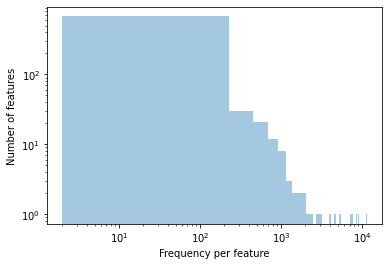

In [4]:
#
table                       = Artifact.load(workdir+'/feature_table/table.qza')
rep_seq                     = Artifact.load(workdir+'/rep_seq/rep_seq.qza')
phylogenic_tree_rooted_tree = Artifact.load(workdir+'/phylo_tree/rooted_tree.qza')
#
output_viz = feature_table.visualizers.summarize(table,sample_metadata) 
output_viz.visualization

# Input the variables

In [5]:
Max_depth         = 9820
Min_depth         = 897   #approximation
Max_feature_depth = 3909        #depth with maximum features
Step              = 2500
rarefy_list       = np.arange(Min_depth,Max_depth,Step)
rarefy_list       = np.append(rarefy_list,Max_feature_depth)

In [40]:
for sampling_depth in rarefy_list:
    #
    print('Calculating diversity metrics for '+str(sampling_depth))
    #
    Path(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)).mkdir(parents=True, exist_ok=True)
    #
    core_metrics = diversity.pipelines.core_metrics_phylogenetic(table = table,
                                                             phylogeny = phylogenic_tree_rooted_tree,
                                                             sampling_depth = sampling_depth,
                                                             metadata = sample_metadata,
                                                             ) 
    #
    table_rarefied = core_metrics.rarefied_table
    non_phylo_metric_list = ['observed_features','shannon']
    col_names =  ['observed_features', 'shannon', 'Faith']
    temp_alpha  = pd.DataFrame(columns = col_names)
    for met in non_phylo_metric_list:
        alpha_metric = alpha(
                       table      =       table_rarefied,
                       metric     =       met
                             )
        Path(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met)).mkdir(parents=True, exist_ok=True)
        alpha_metric.alpha_diversity.export_data(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met))
        alpha_data      = pd.read_csv(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met)+'/alpha-diversity.tsv',sep='\t',index_col=[0])
        temp_alpha[met] = alpha_data.iloc[:,0]
    core_metrics.faith_pd_vector.export_data(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/faith_pd')
    faith_data = pd.read_csv(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/faith_pd/alpha-diversity.tsv',sep='\t',index_col=[0])
    temp_alpha['Faith'] = faith_data.iloc[:,0]
    temp_alpha.to_csv(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/alpha_diversity.csv')
    #
    table_rarefied = core_metrics.rarefied_table
    beta_metric_list = ['braycurtis','jaccard']
    for met in beta_metric_list:
        beta_metric = beta(
                       table      =       table_rarefied,
                       metric     =       met
                             )
        Path(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met)).mkdir(parents=True, exist_ok=True)
        beta_metric.distance_matrix.export_data(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met))

    beta_metric_list = ['unweighted_unifrac','weighted_unifrac']
    for met in beta_metric_list:
        beta_metric = beta_phylogenetic(
                       table      =       table_rarefied,
                       metric     =       met,
                       phylogeny  = phylogenic_tree_rooted_tree
                             )
        Path(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met)).mkdir(parents=True, exist_ok=True)
        beta_metric.distance_matrix.export_data(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met))

Calculating diversity metrics for 897


/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.013522465080301867 and the largest is 3.787971034135235.
  RuntimeWarning
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare 

Calculating diversity metrics for 3397


/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00450240378183084 and the largest is 2.619973921356427.
  RuntimeWarning
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare t

Calculating diversity metrics for 5897


/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0030909390868172314 and the largest is 2.120710335461436.
  RuntimeWarning
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare

Calculating diversity metrics for 8397


/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Calculating diversity metrics for 3909


/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.001319425759144815 and the largest is 1.7986538748823198.
  RuntimeWarning
/Users/alchemist/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare

List of alpha metrics: 'dominance', 'simpson_e', 'heip_e', 'mcintosh_e',
    'simpson', 'singles', 'doubles', 'margalef', 'chao1_ci', 'robbins',
    'gini_index', 'shannon', 'brillouin_d', 'fisher_alpha', 'chao1',
    'mcintosh_d', 'lladser_pe', 'observed_features', 'enspie',
    'kempton_taylor_q', 'ace', 'michaelis_menten_fit', 'esty_ci', 'pielou_e',
    'osd', 'berger_parker_d', 'menhinick', 'goods_coverage', 'strong' \
List of beta metric: 'rogerstanimoto', 'kulsinski', 'sokalmichener',
    'dice', 'braycurtis', 'matching', 'canberra_adkins', 'jensenshannon',
    'sqeuclidean', 'hamming', 'sokalsneath', 'canberra', 'chebyshev',
    'seuclidean', 'aitchison', 'yule', 'cosine', 'correlation', 'minkowski',
    'euclidean', 'russellrao', 'jaccard', 'cityblock'

In [39]:
alpha_data = pd.read_csv(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/shannon/alpha-diversity.tsv',sep='\t',index_col=[0])
alpha_data

,shannon_entropy
L1S105,4.004631
L1S140,3.726095
L1S208,4.370518
L1S257,4.740285
L1S281,4.583463
L1S57,4.126907
L1S76,3.560113
L1S8,3.079887
L2S155,5.069048
L2S175,4.840492


In [25]:
temp_alpha = []
alpha_data      = pd.read_csv(str(workdir)+'/diversity_analysis/sampling_depth_'+str(sampling_depth)+'/'+str(met)+'/alpha-diversity.tsv',sep='\t',index_col=[0])
temp_alpha      = temp_alpha.append(alpha_data.iloc[:,0])

In [29]:
temp_alpha = []
temp_alpha

[]

In [31]:
alpha_data.iloc[:,0].values

array([3.8323405 , 3.6729354 , 4.47112102, 4.63101647, 4.66813325,
       4.1255213 , 3.39258684, 3.25388338, 4.99657172, 4.99982091,
       4.35764257, 6.37486462, 3.894814  , 4.57782302, 4.46736162,
       5.85031561, 2.87526385, 4.32133295, 4.46220149, 4.32602691,
       5.23392584, 3.57582856, 5.26456478, 5.37278694, 6.03270422,
       3.62329039, 3.13180923, 3.26744106, 3.72270281, 3.3075086 ,
       3.33305559, 3.09603217, 3.36584527, 4.15277199])